# I(Q) calculation

In [1]:
import os
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
%matplotlib notebook

import warnings
warnings.filterwarnings('ignore', module='numpy')
warnings.filterwarnings('ignore')

In [2]:
from mantid.simpleapi import mtd
from mantid import simpleapi as api
#from reduction_workflow.instruments.sans.sns_command_interface import *

In [3]:
from drtsans.mono import biosans
from collections import namedtuple
import drtsans

# Reduction options

- Direct beam @ 7m: r815
- Flood H20 @ 7m:  r821
- Dark current: r795

In [10]:
config = dict(sample_offset=0, # 340
              detector_offset=0,
              dark_current="/HFIR/CG3/IPTS-23782/nexus/CG3_795.nxs.h5",
              flood="/HFIR/CG3/IPTS-23782/nexus/CG3_821.nxs.h5",
              prepared_flood = '/HFIR/CG3/IPTS-23782/shared/CG3_flood_821.h5',
             )

mask_file = "/SNS/users/m2d/git/analysis_playground/eqsans/notebooks/data/EQSANS_104088_mask.xml"
mask_nxs = "/SNS/users/m2d/git/analysis_playground/eqsans/notebooks/data/EQSANS_104088_mask.nxs"

In [5]:
def load_data(filename, mask_wing=True, center_x=None, center_y=None, center_y_wing=None, output_workspace=None):
    ws = api.LoadEventNexus(Filename=filename, OutputWorkspace=output_workspace)
    ws = api.HFIRSANS2Wavelength(ws, OutputWorkspace=output_workspace)
    api.LoadInstrument(Workspace=ws,
                   Filename='/SNS/users/3y9/Desktop/BIOSANS-commisioning/BIOSANS_Definition_2019_2100.xml',
                   RewriteSpectraMap='True')

    # Mask wing
    if mask_wing:
        api.MaskDetectors(ws, ComponentList='wing_detector')
        
    if center_x is not None and center_y is not None and center_y_wing is not None:
        biosans.center_detector(ws, center_x=center_x, center_y=center_y, center_y_wing=center_y_wing)

    return ws

In [6]:
#ws = load_data("/HFIR/CG3/IPTS-23782/nexus/CG3_957.nxs.h5")
def plot_det(ws):
    nx = 192
    ny = 256
    pixel_x = 5.5
    pixel_y = 4.297

    # Wavelengths
    bounds_wl = ws.readX(0)
    wl = 0.5 * (bounds_wl[1:] + bounds_wl[:-1])

    data = ws.extractY()[0:49152]
    err = ws.extractE()[0:49152]

    print(data.shape)

    counts = data.reshape((nx,ny,len(wl)))
    d_counts = err.reshape((nx,ny,len(wl)))
    _counts = np.sum(counts, axis=2)

    print(counts.shape)
    print(counts[:,:,0].shape)
    plt.figure()
    plt.pcolor(_counts.T)

# Find beam center

In [7]:
# The new way of dealing with the beam center is in real space, relative to the center of the detector.
# The EQSANS detector is 192 x 256 pixels, and the pixel sizes are 5.5 mm x 4.3 mm
x_center, y_center = [-0.01230061, -0.0351677 ]
beam_center_drt = (-0.012300612863652916, -0.035167700781957245, -0.034614155228279528)

print("Old reduction's beam center in real space: %g %g" % (x_center, y_center))

db_ws = load_data("/HFIR/CG3/IPTS-23782/nexus/CG3_815.nxs.h5", output_workspace='beam')

center = biosans.find_beam_center(db_ws)

print("Beam center found: %g %g %g" % (center[0], center[1], center[2]))

config['center_x'] = center[0]
config['center_y'] = center[1]
config['center_y_wing'] = center[2]

Old reduction's beam center in real space: -0.0123006 -0.0351677
Beam center found: -0.0123006 -0.0351677 -0.0346142


# Sensitivity

In [77]:
flood_ws = load_data(config['flood'],
                     center_x=config['center_x'],
                     center_y=config['center_y'],
                     center_y_wing=config['center_y_wing'],
                     output_workspace='CG3_flood')
drtsans.calculate_sensitivity_correction(flood_ws, 
                                         filename='/HFIR/CG3/IPTS-23782/shared/CG3_flood_821.h5',
                                         output_workspace='CG3_sensitivity')
config['prepared_flood'] = '/HFIR/CG3/IPTS-23782/shared/CG3_flood_821.h5'

Workspace2D
Title: Flood 1mm H2O 7m
Histograms: 90112
Bins: 1
Histogram
X axis: Wavelength / Angstrom
Y axis: Counts
Distribution: False
Instrument: BIOSANS (2019-Jan-01 to 2100-Dec-31)Instrument from: /SNS/users/3y9/Desktop/BIOSANS-commisioning/BIOSANS_Definition_2019_2100.xml

Parameters from: /SNS/users/m2d/.mantid/instrument/BIOSANS_Parameters.xml
Run start: 2019-Nov-02 23:51:20
Run end:  2019-Nov-03 04:51:20

# AgBeh

In [8]:
%%time
ws = load_data("/HFIR/CG3/IPTS-23782/nexus/CG3_957.nxs.h5",
               center_x=config['center_x'],
               center_y=config['center_y'],
               center_y_wing=config['center_y_wing'],
               output_workspace='CG3_957')

# Dark current
dark_ws = load_data(config['dark_current'],
                    center_x=config['center_x'],
                    center_y=config['center_y'],
                    center_y_wing=config['center_y_wing'],
                    output_workspace='CG3_dark')
biosans.subtract_dark_current(ws, dark_ws)

# Normalization
biosans.normalize_by_time(ws)

# Solid angle
#biosans.solid_angle_correction(ws)

# Sensitivity
drtsans.apply_sensitivity_correction(ws, sensitivity_filename=config['prepared_flood'])

# Transmission

# Background

# Save output
#api.SaveNexus(InputWorkspace=ws, Filename="/HFIR/CG3/IPTS-23782/shared/CG3_reduced_957.hf5")

CPU times: user 8.28 s, sys: 1.56 s, total: 9.83 s
Wall time: 8.48 s


Workspace2D
Title: AgBeh 1mm FDD=5m
Histograms: 90112
Bins: 1
Histogram
X axis: Wavelength / Angstrom
Y axis: Counts
Distribution: False
Instrument: BIOSANS (2019-Jan-01 to 2100-Dec-31)Instrument from: /SNS/users/3y9/Desktop/BIOSANS-commisioning/BIOSANS_Definition_2019_2100.xml

Parameters from: /SNS/users/m2d/.mantid/instrument/BIOSANS_Parameters.xml
Run start: 2019-Nov-04 00:24:30
Run end:  2019-Nov-04 00:54:40

None


<ErrorbarContainer object of 3 artists>

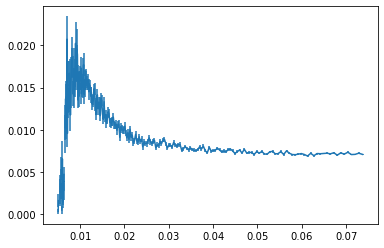

In [9]:
BinningParams = namedtuple('BinningParams', 'min max bins')

q_data = drtsans.convert_to_q(ws, mode='scalar')

iq_output = biosans.bin_intensity_into_q1d(q_data, bin_params=BinningParams(min=0.001, max=0.25, bins=200),
                               linear_binning=False)#, bin_method=1)

print(iq_output.wavelength)
fig, ax = plt.subplots()
ax.errorbar(iq_output.mod_q, iq_output.intensity, yerr=iq_output.error, label="AgBeh")


(49152, 1)
(192, 256, 1)
(192, 256)


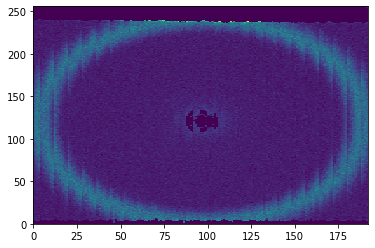

In [15]:
plot_det(ws)